In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

## Load Appian Stock Data

In [2]:
date = '2019-05-31'
appn = pdr.get_data_yahoo('APPN',date)
appn.drop('Adj Close', axis=1, inplace=True)
appn.head()

,High,Low,Open,Close,Volume
Date,,,,,
2019-05-31,36.520000,35.436001,35.520000,36.130001,331800
2019-06-03,36.570000,32.650002,36.000000,33.299999,677900
2019-06-04,34.560001,33.459999,33.919998,34.360001,507700
2019-06-05,34.790001,33.040001,34.540001,34.730000,445500
2019-06-06,34.480000,33.150002,34.060001,34.220001,326800


In [3]:
appn['3-day'] = appn['Close'].rolling(3).mean()
appn['9-day'] = appn['Close'].rolling(9).mean()
appn['21-day'] = appn['Close'].rolling(21).mean()
appn['Change'] = (appn.Close-appn.Close.shift())/appn.Close.shift()
appn.tail()

,High,Low,Open,Close,Volume,3-day,9-day,21-day,Change
Date,,,,,,,,,
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,90.676669,86.631111,87.721428,0.072962
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,90.986669,87.454445,87.013333,-0.027243
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,92.113335,88.414445,86.472857,-0.004923
2021-06-07,95.650002,88.879997,91.000000,94.699997,514400,92.356667,89.593334,86.271428,0.041117
2021-06-08,105.240303,95.949997,95.959999,100.650002,867286,95.436666,91.547779,86.860952,0.062830


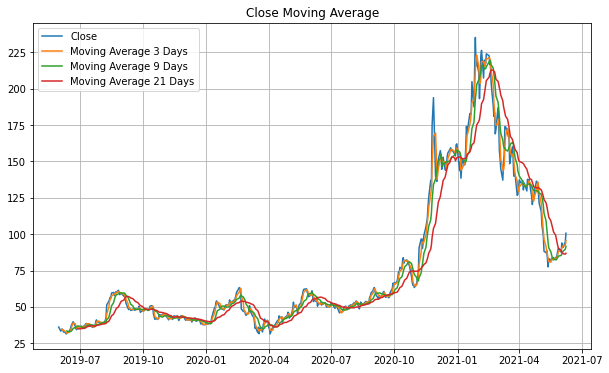

In [4]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("Close Moving Average")
plt.plot(appn['Close'],label='Close')
plt.plot(appn['3-day'],label='Moving Average 3 Days')
plt.plot(appn['9-day'],label='Moving Average 9 Days')
plt.plot(appn['21-day'],label='Moving Average 21 Days')
plt.legend(loc=2)

## Zoom in the changing period

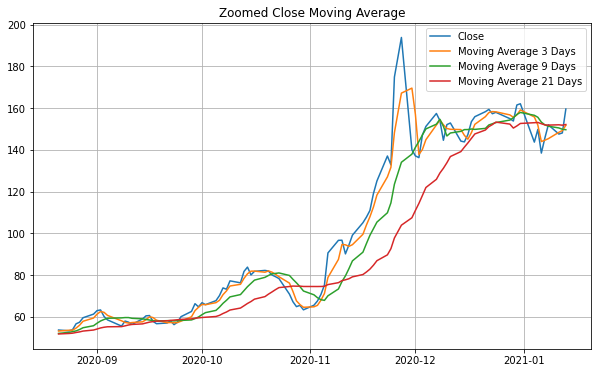

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("Zoomed Close Moving Average")
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['3-day'][-200:-100],label='Moving Average 3 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.plot(appn['21-day'][-200:-100],label='Moving Average 21 Days')
plt.legend(loc=1)

In [6]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-9-21'] = np.where(appn['9-day'] > appn['21-day'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-9-21'] = np.where(appn['9-day'] < appn['21-day'],-1,appn['position-9-21'])

<AxesSubplot:title={'center':'9-21 Buy/Sell Activity'}, xlabel='Date'>

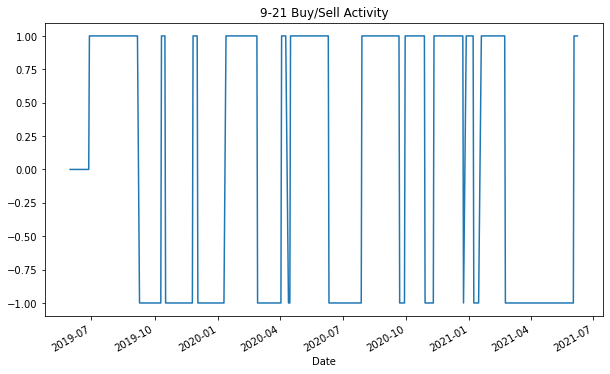

In [7]:
plt.title("9-21 Buy/Sell Activity")
appn['position-9-21'].plot(figsize=(10,6))

Text(0.5, 1.0, '9-21 Moving Average Performance vs. Buy/Hold Performance')

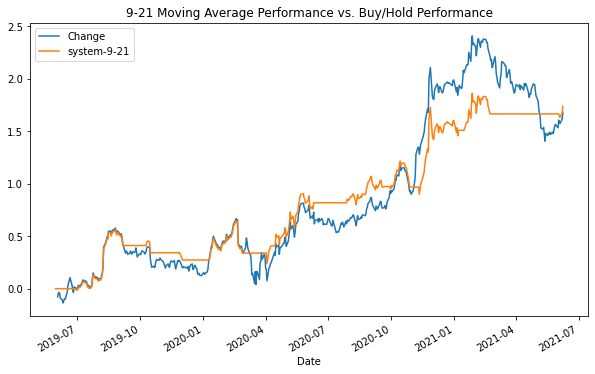

In [8]:
# Whether we are making money with this system
appn['system-9-21'] = np.where(appn['position-9-21'] > 0, appn['position-9-21']* appn['Change'],0)
appn[['Change','system-9-21']].cumsum().plot(figsize=(10,6))
plt.title("9-21 Moving Average Performance vs. Buy/Hold Performance")

Text(0.5, 1.0, '3-9 Buy/Sell Activity')

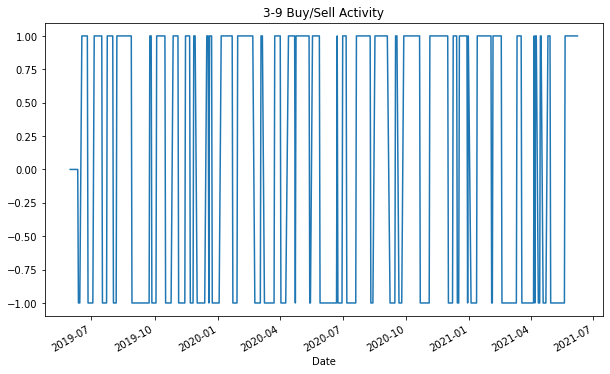

In [9]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-3-9'] = np.where(appn['3-day'] > appn['9-day'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-3-9'] = np.where(appn['3-day'] < appn['9-day'],-1,appn['position-3-9'])
appn['position-3-9'].plot(figsize=(10,6))
plt.title("3-9 Buy/Sell Activity")

Text(0.5, 1.0, '3-9 Moving Average Performance vs. Buy/Hold Performance')

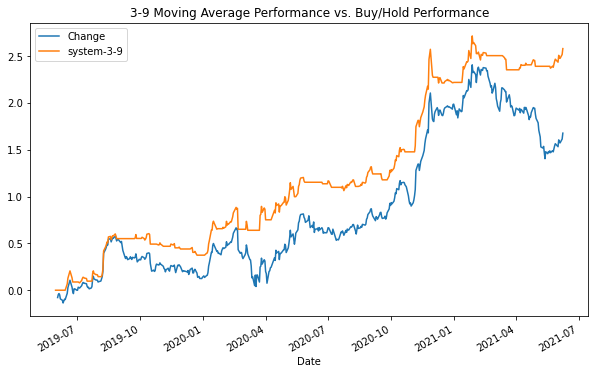

In [10]:
# Whether we are making money with this system
appn['system-3-9'] = np.where(appn['position-3-9'] > 0, appn['position-3-9']* appn['Change'],0)
appn[['Change','system-3-9']].cumsum().plot(figsize=(10,6))
plt.title("3-9 Moving Average Performance vs. Buy/Hold Performance")

## Prepare data for DGIM processing

In [11]:
bit_depth = 16
num_buckets = 5
quiet = True
appn_list = appn['Close'].tolist()
appn_3day_list = appn['3-day'].tolist()
appn_9day_list = appn['9-day'].tolist()
appn_21day_list = appn['21-day'].tolist()
appn_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in appn_list ]
print(appn_list[0],appn_list_bin[0], len(appn_list_bin))

36.130001068115234 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0] 510


In [12]:
from ipynb.fs.full.DGIMMovingAverage import *

## 3, 9, 21 day moving average with DGIM

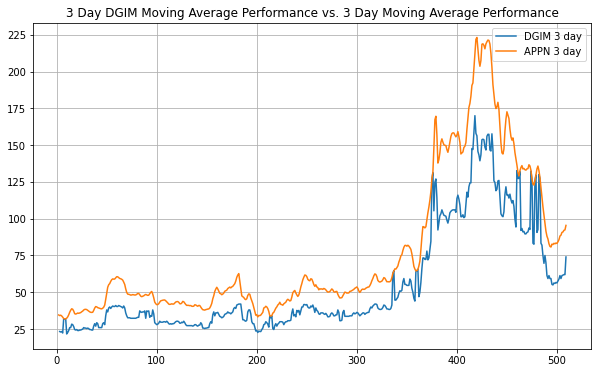

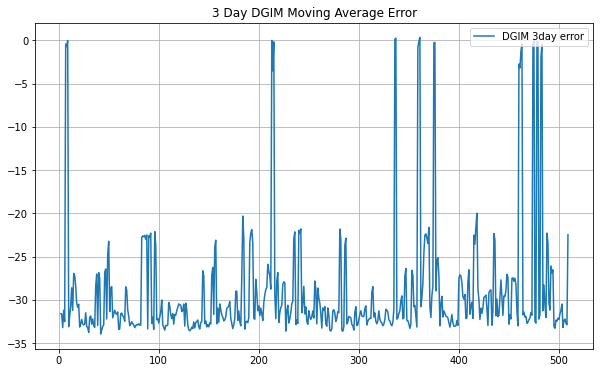

In [13]:
dgim_3day = DGIMMovingAverage(appn_list_bin, 3, num_buckets, bit_depth, appn_3day_list, quiet)
appn['3-day-dgim'] = dgim_3day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("3 Day DGIM Moving Average Performance vs. 3 Day Moving Average Performance")
plt.plot(range(len(dgim_3day.mov_avg)), dgim_3day.mov_avg, label = "DGIM 3 day")
plt.plot(range(len(dgim_3day.mov_avg)), appn_3day_list, label = "APPN 3 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("3 Day DGIM Moving Average Error")
plt.plot(range(len(dgim_3day.error)), dgim_3day.error, label = "DGIM 3day error")
plt.legend(loc=1)

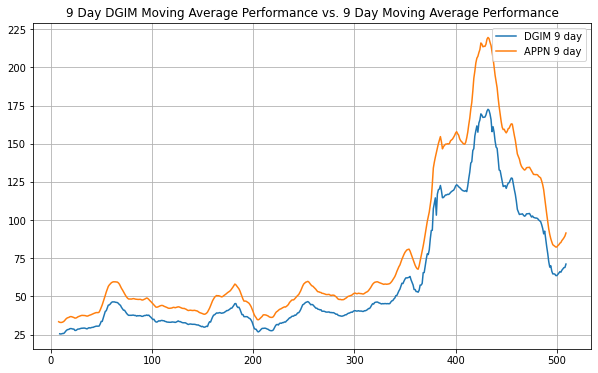

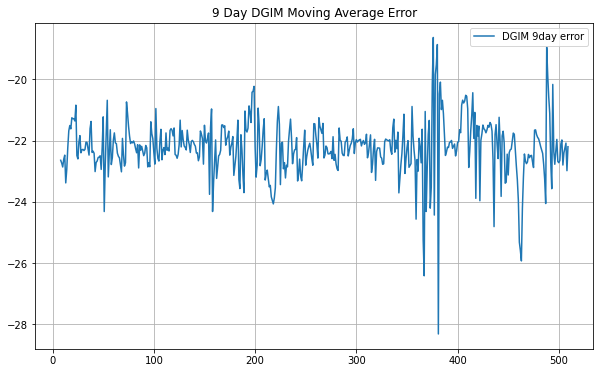

In [14]:
dgim_9day = DGIMMovingAverage(appn_list_bin, 9, num_buckets, bit_depth, appn_9day_list, quiet)
appn['9-day-dgim'] = dgim_9day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("9 Day DGIM Moving Average Performance vs. 9 Day Moving Average Performance")
plt.plot(range(len(dgim_9day.mov_avg)), dgim_9day.mov_avg, label = "DGIM 9 day")
plt.plot(range(len(dgim_9day.mov_avg)), appn_9day_list, label = "APPN 9 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("9 Day DGIM Moving Average Error")
plt.plot(range(len(dgim_9day.error)), dgim_9day.error, label = "DGIM 9day error")
plt.legend(loc=1)

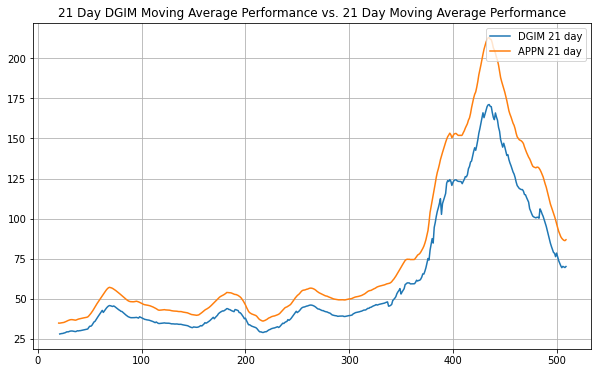

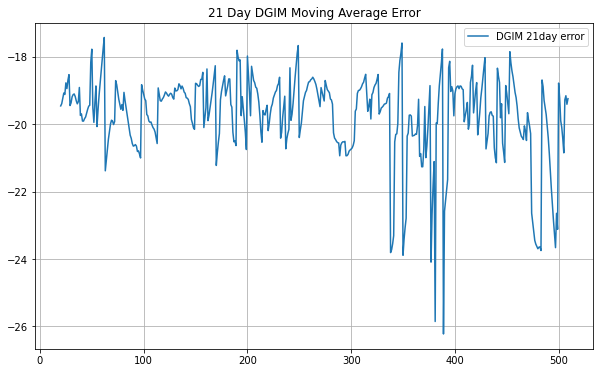

In [15]:
dgim_21day = DGIMMovingAverage(appn_list_bin, 21, num_buckets, bit_depth, appn_21day_list, quiet)
appn['21-day-dgim'] = dgim_21day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("21 Day DGIM Moving Average Performance vs. 21 Day Moving Average Performance")
plt.plot(range(len(dgim_21day.mov_avg)), dgim_21day.mov_avg, label = "DGIM 21 day")
plt.plot(range(len(dgim_21day.mov_avg)), appn_21day_list, label = "APPN 21 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("21 Day DGIM Moving Average Error")
plt.plot(range(len(dgim_21day.mov_avg)), dgim_21day.error, label = "DGIM 21day error")
plt.legend(loc=1)


In [16]:
appn.tail()

,High,Low,Open,Close,Volume,3-day,9-day,21-day,Change,position-9-21,system-9-21,position-3-9,system-3-9,3-day-dgim,9-day-dgim,21-day-dgim
Date,,,,,,,,,,,,,,,,
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,90.676669,86.631111,87.721428,0.072962,-1,0.000000,1,0.072962,61.333333,67.222222,69.428571
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,90.986669,87.454445,87.013333,-0.027243,1,-0.027243,1,-0.027243,61.666667,68.000000,70.238095
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,92.113335,88.414445,86.472857,-0.004923,1,-0.004923,1,-0.004923,62.000000,68.888889,69.904762
2021-06-07,95.650002,88.879997,91.000000,94.699997,514400,92.356667,89.593334,86.271428,0.041117,1,0.041117,1,0.041117,62.000000,69.000000,69.523810
2021-06-08,105.240303,95.949997,95.959999,100.650002,867286,95.436666,91.547779,86.860952,0.062830,1,0.062830,1,0.062830,74.000000,71.222222,70.142857


## 9/21 DGIM Comparison

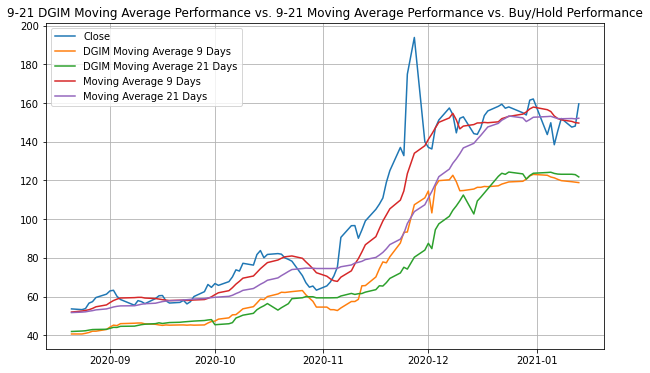

In [17]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("9-21 DGIM Moving Average Performance vs. 9-21 Moving Average Performance vs. Buy/Hold Performance")
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['9-day-dgim'][-200:-100],label='DGIM Moving Average 9 Days')
plt.plot(appn['21-day-dgim'][-200:-100],label='DGIM Moving Average 21 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.plot(appn['21-day'][-200:-100],label='Moving Average 21 Days')
plt.legend(loc=0)

<AxesSubplot:title={'center':'9-21 Buy/Sell Activity'}, xlabel='Date'>

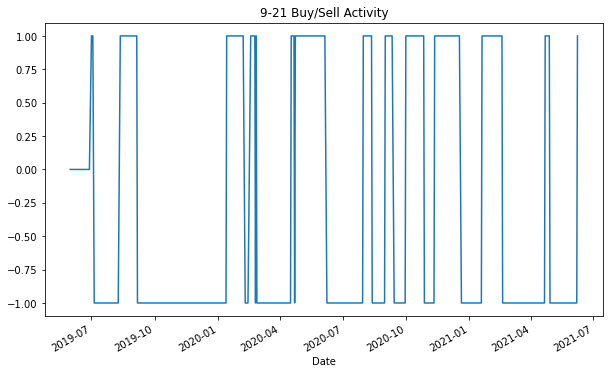

In [18]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-9-21'] = np.where(appn['9-day-dgim'] > appn['21-day-dgim'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-9-21'] = np.where(appn['9-day-dgim'] < appn['21-day-dgim'],-1,appn['position-dgim-9-21'])
plt.title("9-21 Buy/Sell Activity")
appn['position-dgim-9-21'].plot(figsize=(10,6))

,Change,system-dgim-9-21
Date,,
2021-06-02,1.604827,1.082922
2021-06-03,1.577584,1.082922
2021-06-04,1.572662,1.082922
2021-06-07,1.613778,1.082922
2021-06-08,1.676608,1.145752


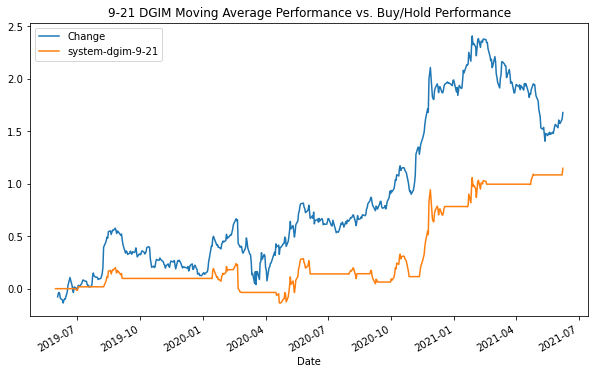

In [19]:
# Whether we are making money with this system
appn['system-dgim-9-21'] = np.where(appn['position-dgim-9-21'] > 0, appn['position-dgim-9-21']* appn['Change'],0)
appn[['Change','system-dgim-9-21']].cumsum().plot(figsize=(10,6))
plt.title("9-21 DGIM Moving Average Performance vs. Buy/Hold Performance")
appn[['Change','system-dgim-9-21']].cumsum().tail()

,system-9-21,system-dgim-9-21
Date,,
2021-06-02,1.663284,1.082922
2021-06-03,1.636042,1.082922
2021-06-04,1.631119,1.082922
2021-06-07,1.672236,1.082922
2021-06-08,1.735066,1.145752


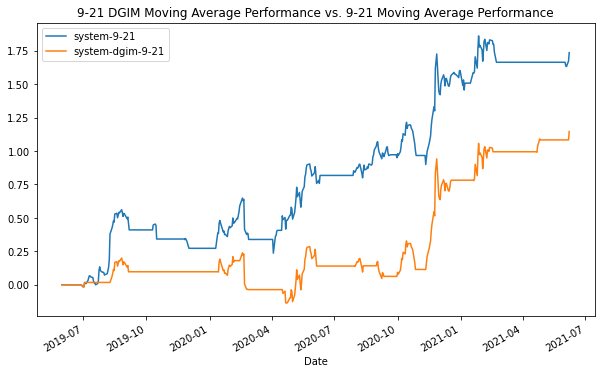

In [20]:
appn[['system-9-21','system-dgim-9-21']].cumsum().plot(figsize=(10,6))
plt.title("9-21 DGIM Moving Average Performance vs. 9-21 Moving Average Performance")
appn[['system-9-21','system-dgim-9-21']].cumsum().tail()

In [21]:
appn.tail()

,High,Low,Open,Close,Volume,3-day,9-day,21-day,Change,position-9-21,system-9-21,position-3-9,system-3-9,3-day-dgim,9-day-dgim,21-day-dgim,position-dgim-9-21,system-dgim-9-21
Date,,,,,,,,,,,,,,,,,,
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,90.676669,86.631111,87.721428,0.072962,-1,0.000000,1,0.072962,61.333333,67.222222,69.428571,-1,0.00000
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,90.986669,87.454445,87.013333,-0.027243,1,-0.027243,1,-0.027243,61.666667,68.000000,70.238095,-1,0.00000
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,92.113335,88.414445,86.472857,-0.004923,1,-0.004923,1,-0.004923,62.000000,68.888889,69.904762,-1,0.00000
2021-06-07,95.650002,88.879997,91.000000,94.699997,514400,92.356667,89.593334,86.271428,0.041117,1,0.041117,1,0.041117,62.000000,69.000000,69.523810,-1,0.00000
2021-06-08,105.240303,95.949997,95.959999,100.650002,867286,95.436666,91.547779,86.860952,0.062830,1,0.062830,1,0.062830,74.000000,71.222222,70.142857,1,0.06283


## 3/9 DGIM comparison

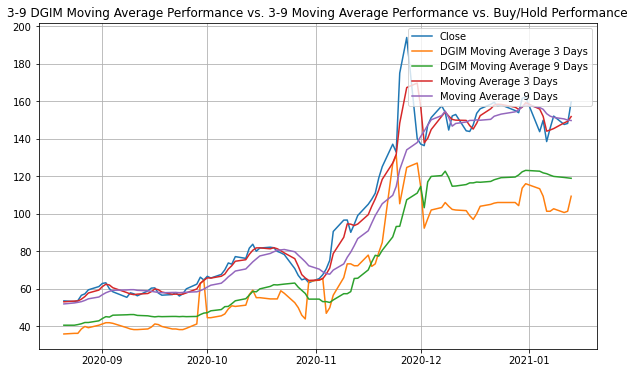

In [22]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title("3-9 DGIM Moving Average Performance vs. 3-9 Moving Average Performance vs. Buy/Hold Performance")
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['3-day-dgim'][-200:-100],label='DGIM Moving Average 3 Days')
plt.plot(appn['9-day-dgim'][-200:-100],label='DGIM Moving Average 9 Days')
plt.plot(appn['3-day'][-200:-100],label='Moving Average 3 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.legend(loc=1)

<AxesSubplot:title={'center':'3-9 Buy/Sell Activity'}, xlabel='Date'>

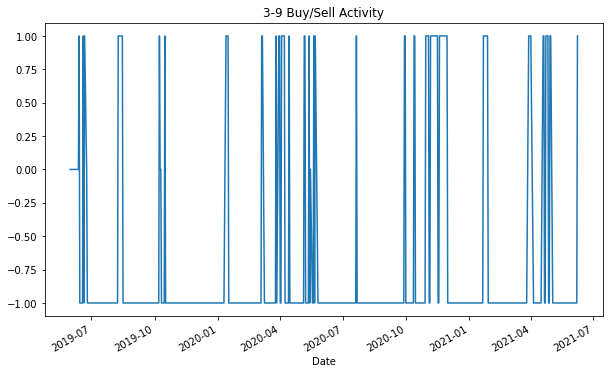

In [23]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-3-9'] = np.where(appn['3-day-dgim'] > appn['9-day-dgim'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-3-9'] = np.where(appn['3-day-dgim'] < appn['9-day-dgim'],-1,appn['position-dgim-3-9'])
plt.title("3-9 Buy/Sell Activity")
appn['position-dgim-3-9'].plot(figsize=(10,6))

,Change,system-dgim-3-9
Date,,
2021-06-02,1.604827,1.532493
2021-06-03,1.577584,1.532493
2021-06-04,1.572662,1.532493
2021-06-07,1.613778,1.532493
2021-06-08,1.676608,1.595323


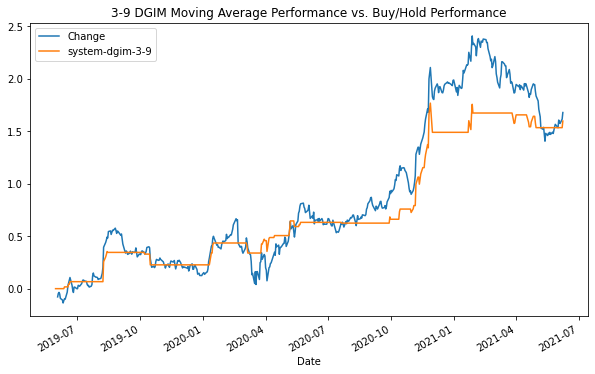

In [24]:
# Whether we are making money with this system
appn['system-dgim-3-9'] = np.where(appn['position-dgim-3-9'] > 0, appn['position-dgim-3-9']* appn['Change'],0)
appn[['Change','system-dgim-3-9']].cumsum().plot(figsize=(10,6))
plt.title("3-9 DGIM Moving Average Performance vs. Buy/Hold Performance")
appn[['Change','system-dgim-3-9']].cumsum().tail()

,system-3-9,system-dgim-3-9
Date,,
2021-06-02,2.507190,1.532493
2021-06-03,2.479947,1.532493
2021-06-04,2.475024,1.532493
2021-06-07,2.516141,1.532493
2021-06-08,2.578971,1.595323


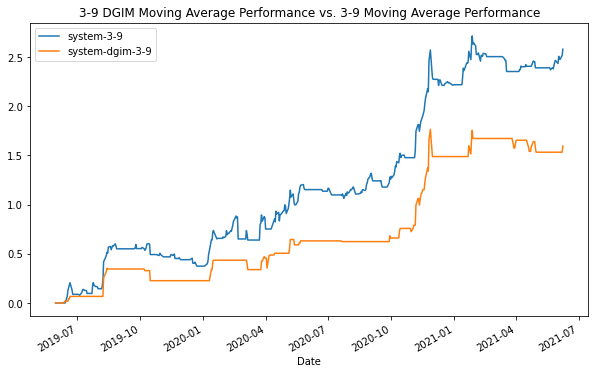

In [25]:
appn[['system-3-9','system-dgim-3-9']].cumsum().plot(figsize=(10,6))
plt.title("3-9 DGIM Moving Average Performance vs. 3-9 Moving Average Performance")
appn[['system-3-9','system-dgim-3-9']].cumsum().tail()

## Normalizing DGIM

<AxesSubplot:title={'center':'Normalized DGIM Moving Average'}, xlabel='Date'>

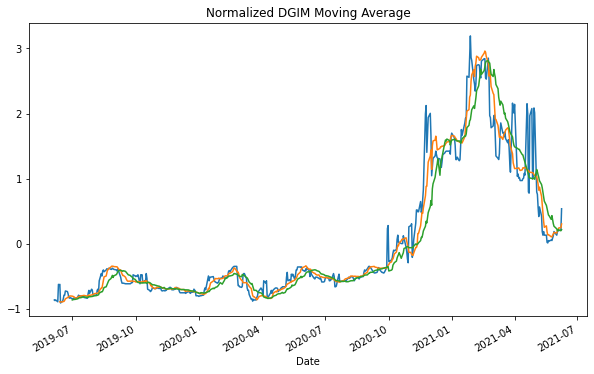

In [26]:
from sklearn import preprocessing

df3 = appn['3-day-dgim']
df9 = appn['9-day-dgim']
df21 = appn['21-day-dgim']

appn['3-day-dgim-norm']=(df3-df3.mean())/df3.std()
appn['9-day-dgim-norm']=(df9-df9.mean())/df9.std()
appn['21-day-dgim-norm']=(df21-df21.mean())/df21.std()

# normalized_df.plot()
plt.title("Normalized DGIM Moving Average")
appn['3-day-dgim-norm'].plot(figsize=(10,6))
appn['9-day-dgim-norm'].plot(figsize=(10,6))
appn['21-day-dgim-norm'].plot(figsize=(10,6))

<AxesSubplot:title={'center':'Buy/Sell Activity'}, xlabel='Date'>

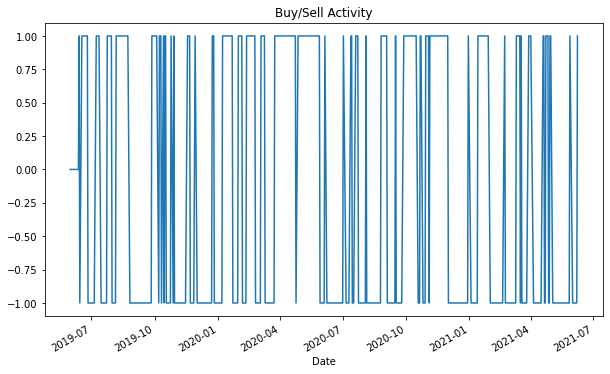

In [27]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-3-9-norm'] = np.where(appn['3-day-dgim-norm'] > appn['9-day-dgim-norm'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-3-9-norm'] = np.where(appn['3-day-dgim-norm'] < appn['9-day-dgim-norm'],-1,appn['position-dgim-3-9-norm'])
plt.title("Buy/Sell Activity")
appn['position-dgim-3-9-norm'].plot(figsize=(10,6))

,Change,system-dgim-3-9-norm
Date,,
2021-06-02,1.604827,2.567754
2021-06-03,1.577584,2.567754
2021-06-04,1.572662,2.567754
2021-06-07,1.613778,2.567754
2021-06-08,1.676608,2.630584


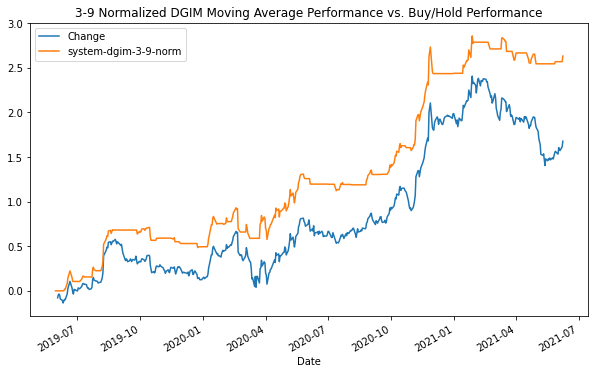

In [28]:
# Whether we are making money with this system
appn['system-dgim-3-9-norm'] = np.where(appn['position-dgim-3-9-norm'] > 0, appn['position-dgim-3-9-norm']* appn['Change'],0)
appn[['Change','system-dgim-3-9-norm']].cumsum().plot(figsize=(10,6))
plt.title("3-9 Normalized DGIM Moving Average Performance vs. Buy/Hold Performance")
appn[['Change','system-dgim-3-9-norm']].cumsum().tail()

,system-dgim-3-9-norm,system-dgim-3-9
Date,,
2021-06-02,2.567754,1.532493
2021-06-03,2.567754,1.532493
2021-06-04,2.567754,1.532493
2021-06-07,2.567754,1.532493
2021-06-08,2.630584,1.595323


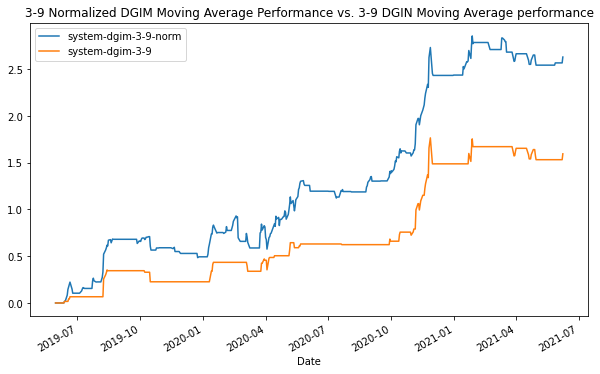

In [29]:
appn[['system-dgim-3-9-norm','system-dgim-3-9']].cumsum().plot(figsize=(10,6))
plt.title("3-9 Normalized DGIM Moving Average Performance vs. 3-9 DGIN Moving Average performance")
appn[['system-dgim-3-9-norm','system-dgim-3-9']].cumsum().tail()

,system-dgim-3-9-norm,system-3-9
Date,,
2021-06-02,2.567754,2.507190
2021-06-03,2.567754,2.479947
2021-06-04,2.567754,2.475024
2021-06-07,2.567754,2.516141
2021-06-08,2.630584,2.578971


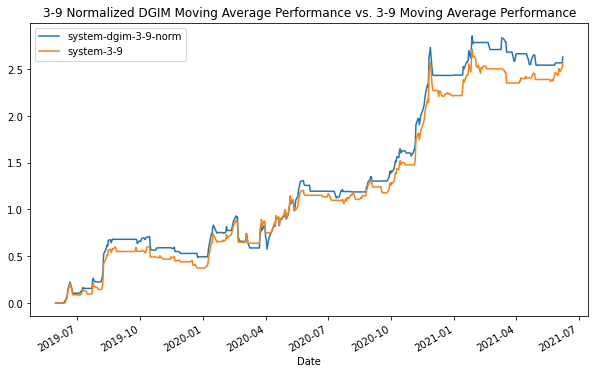

In [30]:
appn[['system-dgim-3-9-norm','system-3-9']].cumsum().plot(figsize=(10,6))
plt.title("3-9 Normalized DGIM Moving Average Performance vs. 3-9 Moving Average Performance")
appn[['system-dgim-3-9-norm','system-3-9']].cumsum().tail()

<AxesSubplot:title={'center':'Buy/Sell Activity'}, xlabel='Date'>

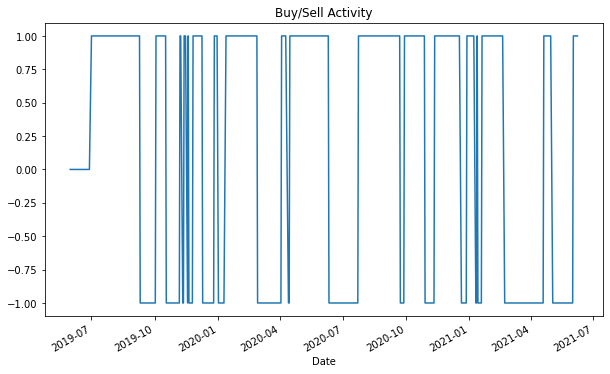

In [31]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-9-21-norm'] = np.where(appn['9-day-dgim-norm'] > appn['21-day-dgim-norm'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-9-21-norm'] = np.where(appn['9-day-dgim-norm'] < appn['21-day-dgim-norm'],-1,appn['position-dgim-9-21-norm'])
plt.title("Buy/Sell Activity")
appn['position-dgim-9-21-norm'].plot(figsize=(10,6))

,Change,system-dgim-9-21-norm
Date,,
2021-06-02,1.604827,1.909199
2021-06-03,1.577584,1.881957
2021-06-04,1.572662,1.877034
2021-06-07,1.613778,1.918151
2021-06-08,1.676608,1.980981


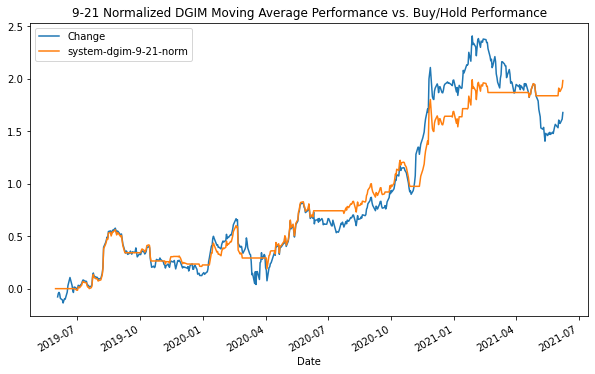

In [32]:
# Whether we are making money with this system
appn['system-dgim-9-21-norm'] = np.where(appn['position-dgim-9-21-norm'] > 0, appn['position-dgim-9-21-norm']* appn['Change'],0)
appn[['Change','system-dgim-9-21-norm']].cumsum().plot(figsize=(10,6))
plt.title("9-21 Normalized DGIM Moving Average Performance vs. Buy/Hold Performance")
appn[['Change','system-dgim-9-21-norm']].cumsum().tail()

,system-dgim-9-21-norm,system-dgim-9-21
Date,,
2021-06-02,1.909199,1.082922
2021-06-03,1.881957,1.082922
2021-06-04,1.877034,1.082922
2021-06-07,1.918151,1.082922
2021-06-08,1.980981,1.145752


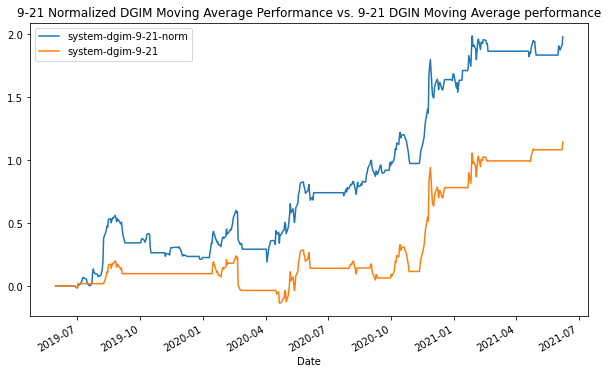

In [33]:
appn[['system-dgim-9-21-norm','system-dgim-9-21']].cumsum().plot(figsize=(10,6))
plt.title("9-21 Normalized DGIM Moving Average Performance vs. 9-21 DGIN Moving Average performance")
appn[['system-dgim-9-21-norm','system-dgim-9-21']].cumsum().tail()

,system-dgim-9-21-norm,system-9-21
Date,,
2021-06-02,1.909199,1.663284
2021-06-03,1.881957,1.636042
2021-06-04,1.877034,1.631119
2021-06-07,1.918151,1.672236
2021-06-08,1.980981,1.735066


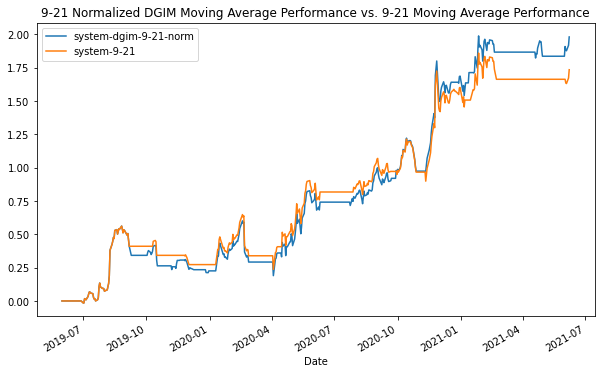

In [34]:
appn[['system-dgim-9-21-norm','system-9-21']].cumsum().plot(figsize=(10,6))
plt.title("9-21 Normalized DGIM Moving Average Performance vs. 9-21 Moving Average Performance")
appn[['system-dgim-9-21-norm','system-9-21']].cumsum().tail()

,system-dgim-3-9-norm,system-dgim-9-21-norm
Date,,
2021-06-02,2.567754,1.909199
2021-06-03,2.567754,1.881957
2021-06-04,2.567754,1.877034
2021-06-07,2.567754,1.918151
2021-06-08,2.630584,1.980981


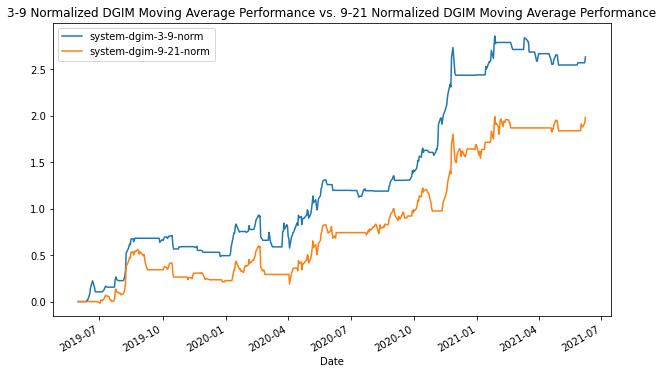

In [35]:
appn[['system-dgim-3-9-norm','system-dgim-9-21-norm']].cumsum().plot(figsize=(10,6))
plt.title("3-9 Normalized DGIM Moving Average Performance vs. 9-21 Normalized DGIM Moving Average Performance")
appn[['system-dgim-3-9-norm','system-dgim-9-21-norm']].cumsum().tail()

## Generate USD Gain

,Close,system-3-9-usd,system-9-21-usd,system-dgim-3-9-norm-usd,system-dgim-9-21-norm-usd
Date,,,,,
2021-06-02,93.970001,296.012304,131.166776,311.123400,165.234627
2021-06-03,91.410004,287.948127,127.593438,311.123400,160.733188
2021-06-04,90.959999,286.530580,126.965305,311.123400,159.941910
2021-06-07,94.699997,298.311844,132.185731,311.123400,166.518234
2021-06-08,100.650002,317.054789,140.490966,330.671295,176.980582


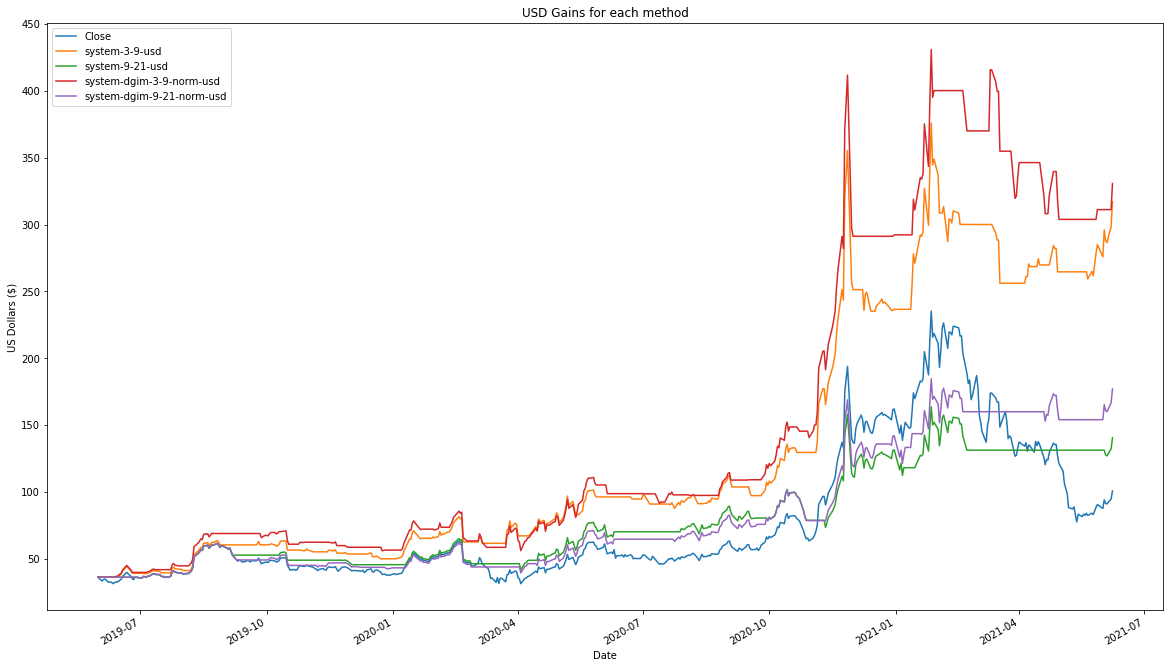

In [36]:
sys39 = [appn['Close'][0]]
sys921 = [appn['Close'][0]]
sysdgimnorm39 = [appn['Close'][0]]
sysdgimnorm921 = [appn['Close'][0]]

for i in range(1,len(appn["Close"])):
    sys39.append(sys39[i-1] * (1+appn["system-3-9"][i]))
    sys921.append(sys921[i-1] * (1+appn["system-9-21"][i]))
    sysdgimnorm39.append(sysdgimnorm39[i-1] * (1+appn["system-dgim-3-9-norm"][i]))
    sysdgimnorm921.append(sysdgimnorm921[i-1] * (1+appn["system-dgim-9-21-norm"][i]))

appn["system-3-9-usd"] = sys39
appn["system-9-21-usd"] = sys921
appn["system-dgim-3-9-norm-usd"] = sysdgimnorm39
appn["system-dgim-9-21-norm-usd"] = sysdgimnorm921    

appn[['Close','system-3-9-usd','system-9-21-usd','system-dgim-3-9-norm-usd','system-dgim-9-21-norm-usd']].fillna(method ='pad').plot(title="APPN USD",figsize=(20,12))
plt.ylabel('US Dollars ($)')
plt.title("USD Gains for each method")

appn[['Close','system-3-9-usd','system-9-21-usd','system-dgim-3-9-norm-usd','system-dgim-9-21-norm-usd']].tail()


## Winning Method: 3-9 Normalized DGIM Moving Average
### Runner Up: 3-9 Moving Average

,Change,system-dgim-3-9-norm,system-3-9,system-dgim-9-21-norm,system-9-21
Date,,,,,
2021-06-02,1.604827,2.567754,2.507190,1.909199,1.663284
2021-06-03,1.577584,2.567754,2.479947,1.881957,1.636042
2021-06-04,1.572662,2.567754,2.475024,1.877034,1.631119
2021-06-07,1.613778,2.567754,2.516141,1.918151,1.672236
2021-06-08,1.676608,2.630584,2.578971,1.980981,1.735066


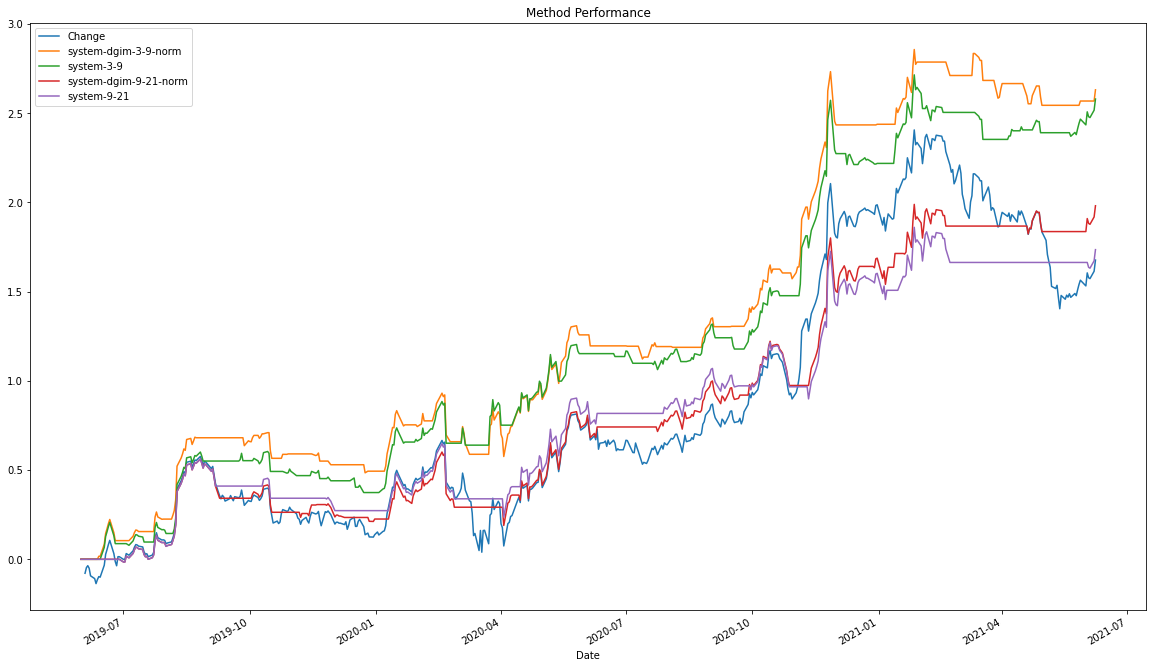

In [37]:
appn[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().plot(figsize=(20,12))
plt.title("Method Performance")
appn[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().tail()